In [17]:
import numpy as np
import pandas as pd
import pickle
import regex as re
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
from preprocessing.parse_rs3_make_objects import EDUPair, EDU
from make_features import load_pairs_target_remove_minor_classes, generate_feature_matrix, \
all_classification_reports, smote_oversampling, smote_oversampling5

In [19]:
def pickle_dump(obj, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(obj, file)

In [20]:
def pickle_load(filepath):
    with open(filepath, 'rb') as file:
        res = pickle.load(file)
    return res

In [21]:
X = pickle_load('X.pkl')
target = pickle_load('target_all.pkl')

In [22]:
# oversampling 5 neighbors
X_res, target_res = smote_oversampling5(X, target) 

(48516, 19850)


In [23]:
pickle_dump(X_res, 'X_res.pkl')
pickle_dump(target_res, 'target_res.pkl')

In [24]:
SEED=669

In [25]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1500, random_state=SEED)

## Cross_val

In [26]:
pred_rf_cv = cross_val_predict(rf, X_res, target_res, cv=5, verbose=10)
all_classification_reports(target_res, pred_rf_cv)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 62.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 129.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 196.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 270.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 358.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 358.9min finished


All together:
                              precision    recall  f1-score   support

              attribution_NS       0.98      1.00      0.99      1866
              attribution_SN       0.95      0.99      0.97      1866
               background_NS       0.99      1.00      1.00      1866
               background_SN       1.00      1.00      1.00      1866
             cause-effect_NS       0.99      1.00      0.99      1866
             cause-effect_SN       0.99      0.99      0.99      1866
                comparison_M       0.99      1.00      1.00      1866
               concession_NS       0.98      1.00      0.99      1866
               concession_SN       0.99      1.00      1.00      1866
                condition_NS       0.99      1.00      0.99      1866
                condition_SN       0.98      1.00      0.99      1866
                  contrast_M       0.96      1.00      0.98      1866
              elaboration_NS       0.84      0.89      0.86      1866
     

In [27]:
del X_res

In [28]:
pickle_dump(pred_rf_cv, 'pred_rf_cv.pkl')

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
def plot_normalized_confusion_matrix_colors(y_true, y_pred, title='Confusion matrix'):
    conf_arr = confusion_matrix(y_true, y_pred)
    labels = ['attribution_NS', 'attribution_SN', 'background_NS', 'background_SN', 'cause-effect_NS', 'cause-effect_SN',
        'comparison_M', 'concession_NS', 'concession_SN', 'condition_NS', 'condition_SN', 'contrast_M', 'elaboration_NS',
        'elaboration_SN', 'evidence_NS', 'evidence_SN', 'interpretation-evaluation_NS', 'interpretation-evaluation_SN',
        'joint_M', 'no_relation', 'preparation_SN', 'purpose_NS', 'purpose_SN', 'restatement_M', 'same-unit_M', 
        'sequence_M']
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure('confusion matrix',figsize=(12, 12))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap='binary', 
                    interpolation='nearest')
    width, height = conf_arr.shape
    plt.colorbar(res)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(range(width), labels[:width], rotation='vertical')
    plt.yticks(range(height), labels[:height])

In [34]:
def plot_confusion_matrix_numbers(y_true, y_pred, title='Confusion matrix'):
    conf_arr = confusion_matrix(y_true, y_pred)
    labels = ['attribution_NS', 'attribution_SN', 'background_NS', 'background_SN', 'cause-effect_NS', 'cause-effect_SN',
        'comparison_M', 'concession_NS', 'concession_SN', 'condition_NS', 'condition_SN', 'contrast_M', 'elaboration_NS',
        'elaboration_SN', 'evidence_NS', 'evidence_SN', 'interpretation-evaluation_NS', 'interpretation-evaluation_SN',
        'joint_M', 'no_relation', 'preparation_SN', 'purpose_NS', 'purpose_SN', 'restatement_M', 'same-unit_M', 
        'sequence_M']
    fig = plt.figure('confusion matrix', figsize=(12, 12))
    plt.clf()
    ax = fig.add_subplot(111)
    width, height = conf_arr.shape
    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)
    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(range(width), labels[:width], rotation='vertical')
    plt.yticks(range(height), labels[:height])

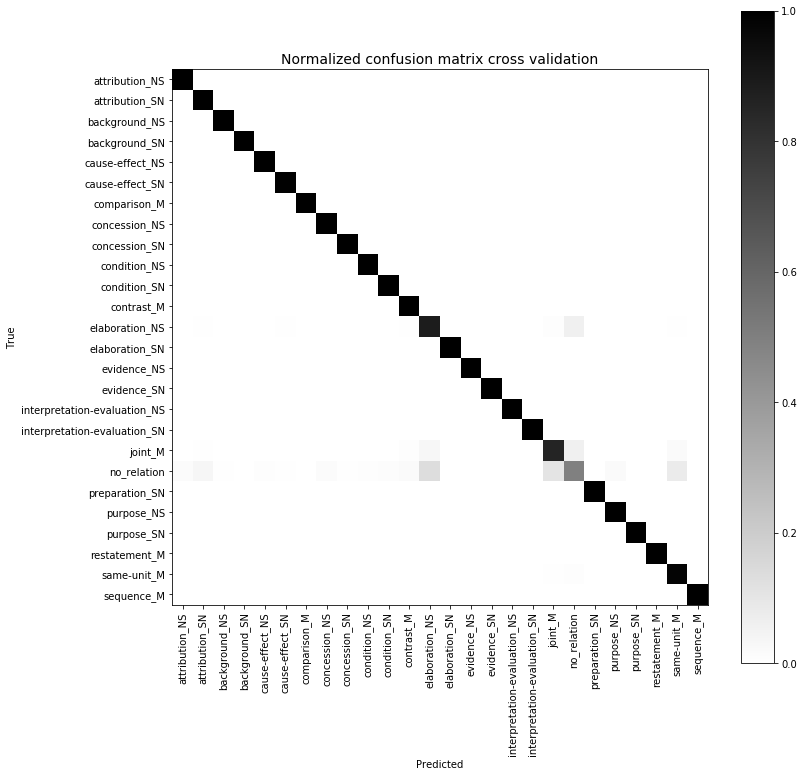

In [35]:
plot_normalized_confusion_matrix_colors(target_res, pred_rf_cv, 'Normalized confusion matrix cross validation')

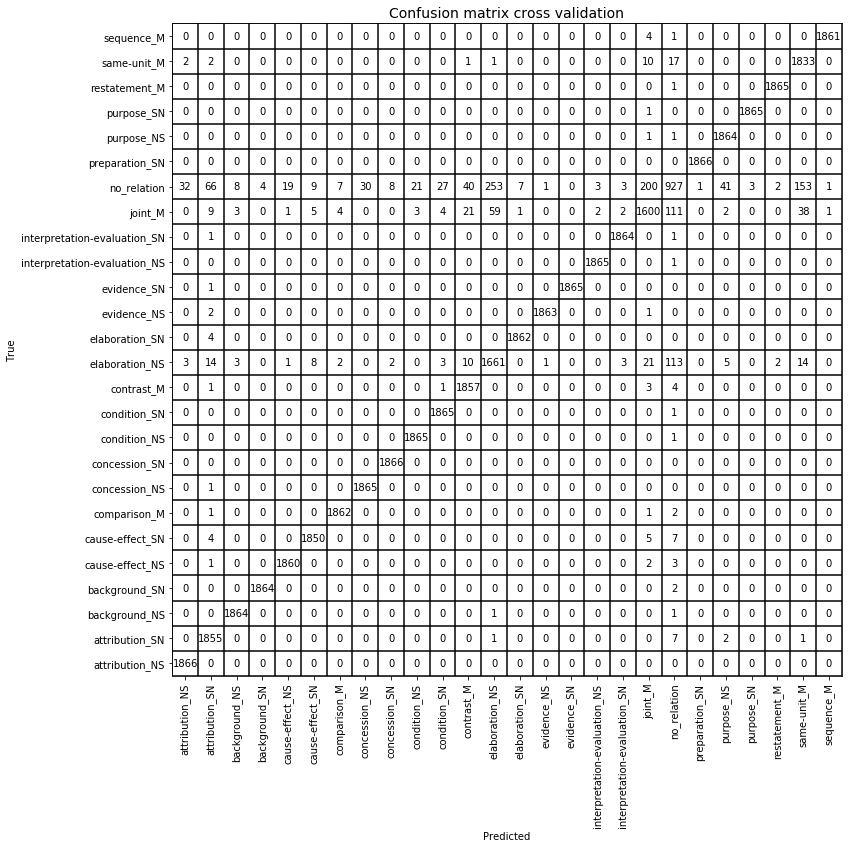

In [36]:
plot_confusion_matrix_numbers(target_res, pred_rf_cv, 'Confusion matrix cross validation')

## Train/test

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target,
                                                    stratify=target, 
                                                    test_size=0.25, random_state=SEED)

In [38]:
X_train_res, y_train_res = smote_oversampling5(X_train, y_train)

(36400, 19850)


In [39]:
pickle_dump(X_train_res, 'X_train_res.pkl')
pickle_dump(X_train, 'X_train.pkl')
pickle_dump(y_train, 'y_train.pkl')
pickle_dump(y_train_res, 'y_train_res.pkl')
pickle_dump(X_test, 'X_test.pkl')
pickle_dump(y_test, 'y_test.pkl')

In [40]:
del X_train
del y_train
del X
del target

In [41]:
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

In [42]:
all_classification_reports(y_test, y_pred)

All together:
                              precision    recall  f1-score   support

              attribution_NS       0.60      0.55      0.57        11
              attribution_SN       0.47      0.63      0.54        38
               background_NS       0.00      0.00      0.00         9
               background_SN       1.00      0.10      0.18        10
             cause-effect_NS       0.62      0.25      0.36        20
             cause-effect_SN       0.40      0.10      0.15        21
                comparison_M       0.50      0.25      0.33        12
               concession_NS       0.36      0.57      0.44         7
               concession_SN       1.00      0.14      0.25         7
                condition_NS       0.40      0.20      0.27        10
                condition_SN       0.58      0.39      0.47        18
                  contrast_M       0.41      0.34      0.38        35
              elaboration_NS       0.46      0.59      0.52       181
     

/home/lena/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
# pickle_dump(rf, 'model_rf_v5.pkl')

In [44]:
del rf

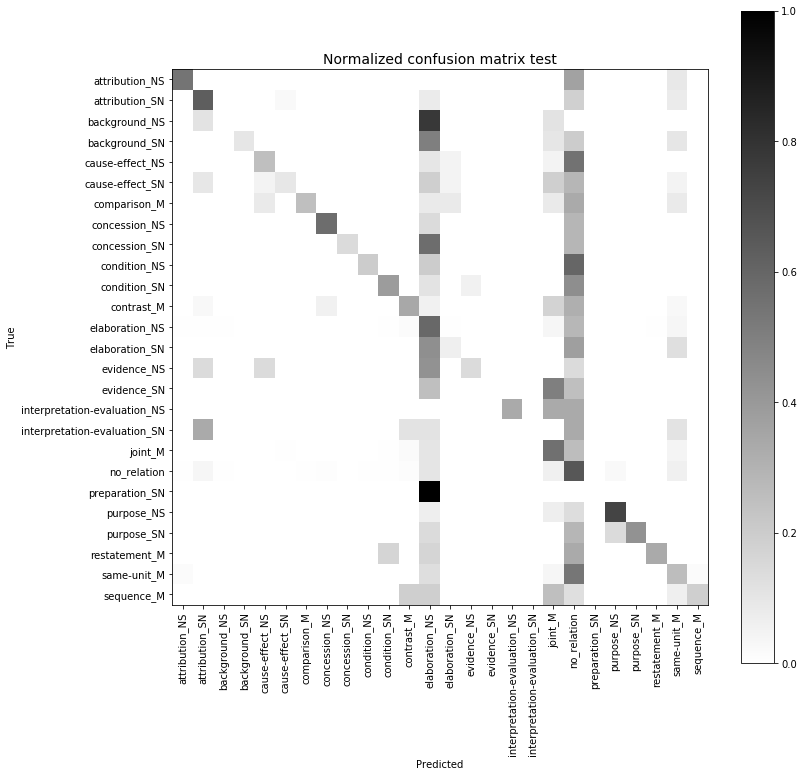

In [45]:
plot_normalized_confusion_matrix_colors(y_test, y_pred, 'Normalized confusion matrix test')

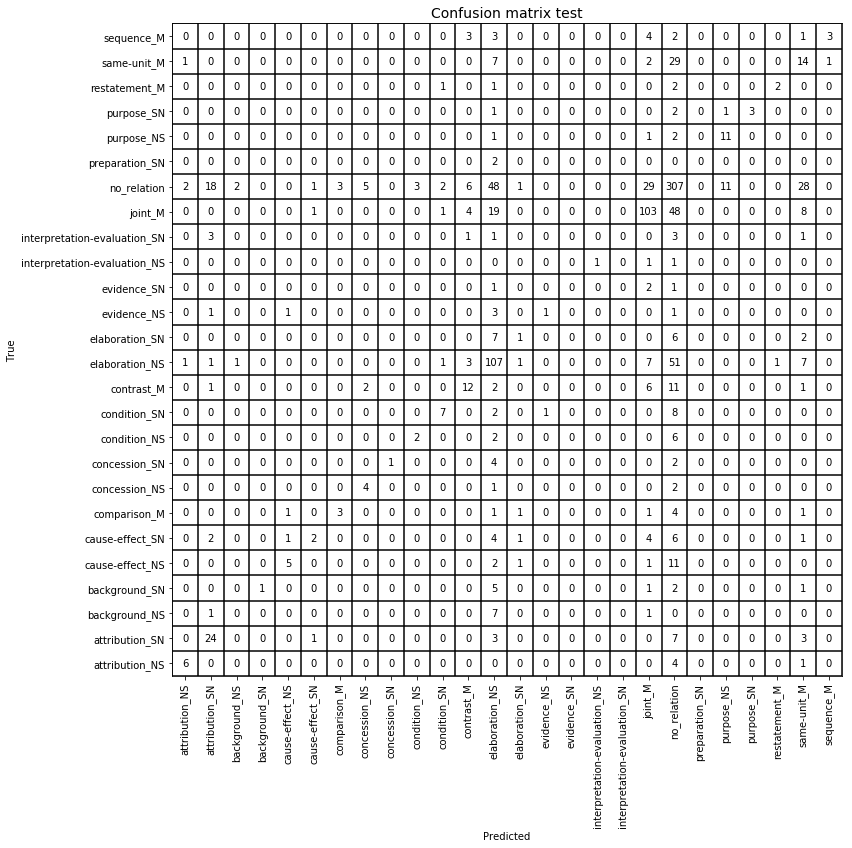

In [46]:
plot_confusion_matrix_numbers(y_test, y_pred, 'Confusion matrix test')

In [48]:
pickle_dump(y_pred, 'y_pred.pkl')